# BERT. Дообучение

In [1]:
# Монтирование google-диска
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Проверка доступной видеокарты
!nvidia-smi

Mon Jun 12 15:15:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Установка и импорт библиотек

In [ ]:
!pip install transformers datasets evaluate accelerate

In [4]:
# Импорт библиотек
from datasets import load_dataset
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import evaluate
import torch

%matplotlib inline
sns.set(style='whitegrid')

In [5]:
# Проверка доступности GPU
torch.cuda.is_available()

True

## Подготовка датасета

Прежде чем пользоваться самой моделью нам необходимо загрузить датасет, токенизировать его и разбить на обучающую и тестовую выбокри. 

In [ ]:
# Загрузка датасета
dataset = load_dataset("csv", data_files="issue_data_encoded_small.csv", data_dir="drive/MyDrive/datasets")

In [ ]:
# Добавление токенизатора
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [8]:
# Функция токенизации
def tokenize_function(data):
    return tokenizer(data["text"], padding="max_length", truncation=True, max_length=384, return_tensors='pt')

In [9]:
# Токенизация текста
dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

In [10]:
# Разделение выборки на обучающую и тестовую
dataset = dataset['train'].train_test_split(test_size=0.2)

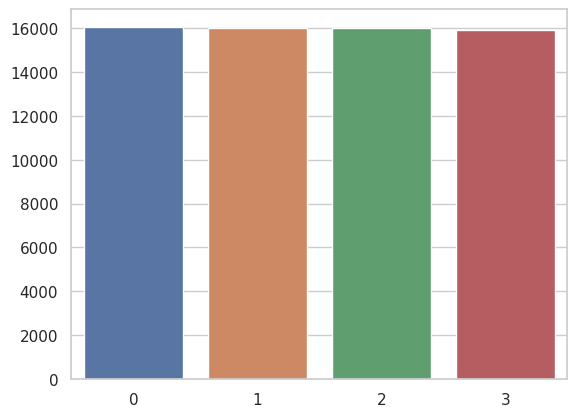

In [11]:
# Распределение меток в обучающей выборке
train_labels, train_count = np.unique(dataset['train']['labels'], return_counts=True)
sns.barplot(x=train_labels, y=train_count)
plt.show()

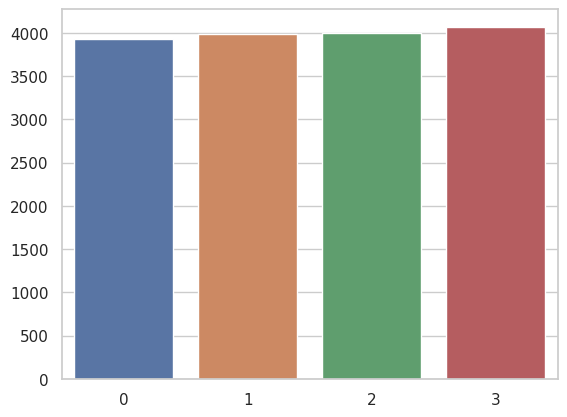

In [12]:
# Распределение меток в тестовой выборке
test_labels, test_count = np.unique(dataset['test']['labels'], return_counts=True)
sns.barplot(x=test_labels, y=test_count)
plt.show()

In [13]:
# Структура датасета
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 64000
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
})

## Обучение модели

In [14]:
id2label = {0 : 'bug', 1 : 'enhancement', 2 : 'documentation', 3 : 'question'}
label2id = {'bug' : 0, 'feature' : 1, 'documentation' : 2, 'question' : 3}

In [ ]:
# Загрузка модели
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=4,
                                                         id2label=id2label, label2id=label2id)

In [16]:
# Настройка контролируемых гиперпараметров
training_args = TrainingArguments(output_dir="drive/MyDrive/models/BERT/BERT_model_data",
                                  logging_dir="drive/MyDrive/models/BERT/BERT_model_data/log",
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=1e-5,
                                  num_train_epochs=4,
                                  fp16=True,
                                  optim="adamw_torch_fused",
                                  remove_unused_columns = True,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [17]:
# Загрузка DataCollator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Загрузка метрик для валидации
metric_f = evaluate.load("f1")

In [19]:
# Функция для подсчёта метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f = metric_f.compute(predictions=predictions, references=labels, average='micro')
    return f

In [20]:
# Описание тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [21]:
# Дообучение модели
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.618100,0.611760,0.784813
2,0.509900,0.606540,0.789687
3,0.431200,0.642339,0.788063
4,0.374300,0.677700,0.789500


TrainOutput(global_step=16000, training_loss=0.5086368885040283, metrics={'train_runtime': 7881.6742, 'train_samples_per_second': 32.48, 'train_steps_per_second': 2.03, 'total_flos': 5.0518229778432e+16, 'train_loss': 0.5086368885040283, 'epoch': 4.0})

In [22]:
# Качество лучшей модели
trainer.evaluate()

{'eval_loss': 0.6065404415130615,
 'eval_f1': 0.7896875,
 'eval_runtime': 132.472,
 'eval_samples_per_second': 120.78,
 'eval_steps_per_second': 7.549,
 'epoch': 4.0}

In [23]:
# Сохранение модели
trainer.save_model("drive/MyDrive/models/BERT/BERT_best_model/")